# Using ElectronGas and dielectric

The `ElectronGas` class is used to hold the physical parameters describing the electrons (e.g. temperature, density, etc.). The dielectric subpackage contains two models (`RPA` and `Mermin`) to compute the dielectric function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from uegdielectric import ElectronGas
from uegdielectric.dielectric import RPA, Mermin

Define some constants that will be used to convert units to atomic units (a.u.) (see [this Wikipedia article](https://en.wikipedia.org/wiki/Hartree_atomic_units) for more details).

In [2]:
# atomic unit of energy: 1 hartree = 27.2114 eV (electron volts)
Ha = 27.2114 # eV
# atomic unit of length: 1 bohr radius = 0.529 A (angstroms)
a0 = 0.529177 # A
# Boltzmann's constant -- used to convert temperature (K, kelvin) to thermal energy (eV)
kB = 8.61733E-5 # eV/K

Define electron temperature and density

In [3]:
# temperature
temp = 10000 # [K]
# convert to thermal energy
t_eV = kB * temp # [eV]
# convert to atomic units [a.u.]
t = t_eV / Ha # [au]

# density
den_cc = 1.807E23 # [electrons]/[cm^3]
# convert to atomic units (convert a0 to [cm] first
d = den_cc * (a0 * 10**-8)**3 # [au]

# Create ElectronGas object
electrons = ElectronGas(t, d)

The chemical potential is automatically calculated, assuming an ideal electron gas with an a density of states (DOS) $g_0(\varepsilon) \propto \sqrt{\varepsilon}$, where $\varepsilon$ is the energy of the free-electronic state.

In [4]:
electrons.chempot

0.426293554933412

It is also possible to use a non-ideal DOS to describe our electron gas. For example, we will assume that the non-ideal DOS $g$ is twice as large as $g_0$:
$$ g(\varepsilon) = 2 g_0(\varepsilon).$$

The code accepts the ratio of the non-ideal to the ideal DOS as an argument, which in this case is $X(\varepsilon) = g(\varepsilon)/g_0(\varepsilon) = 2$.

In [5]:
# DOS ratio - pass as a function of energy
dosratio = lambda x: 2

electrons_nonideal = ElectronGas(t, d, DOSratio=dosratio)

C:\Users\tomhe\Documents\Research\WDM_codes\GitProjects\ueg-dielectric\uegdielectric\electrongas\electrongas.py:51: UserWarning: DOSratio is given but not chemicalpot. Will use the chemical potential computed using the ideal DOS.
  warnings.warn(warnmssg)


This gives a warning because the code is currently unable to compute the chemical potential for a non-ideal DOS (possible new feature?). By default, it will use the ideal DOS to compute the chemical potential, which is not strictly correct since it is not consistent with the density. In practice, the true chemical potential should also be included as an argument:

In [8]:
nonideal_chempot = 0.2666897538
electrons_nonideal_correct = ElectronGas(t, d, DOSratio=dosratio, chemicalpot=nonideal_chempot)

## Computing the dynamic dielectric function

The RPA dielectric function, denoted by $\epsilon(q, \omega)$, are both complex quantities. For a given value wavenumber $q$, we calculate and plot them as a function of the frequency $\omega$.

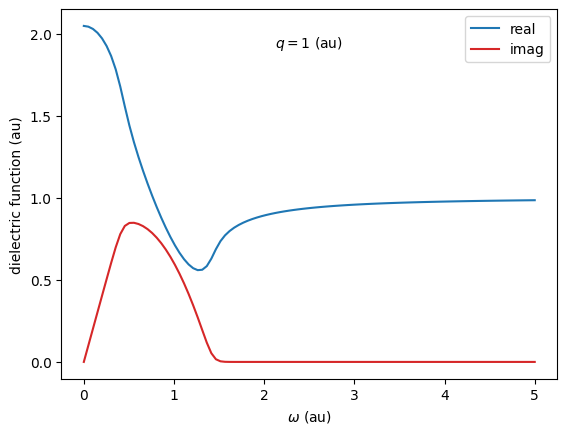

In [15]:
# wavenumber
q = 1 # au
# freqeuncies
ω = np.linspace(0, 5, 100)

# initialize the dielectric class
dielectric_rpa = RPA(electrons)
# compute the dielectric function
rpa_results = dielectric_rpa(q, ω)

# plot the results
plt.plot(ω, rpa_results.real, label='real')
plt.plot(ω, rpa_results.imag, label='imag', color='C3')
plt.xlabel(r"$\omega$ (au)")
plt.ylabel("dielectric function (au)")
plt.text(2.5, 2.0, r"$q = 1$ (au)", {"horizontalalignment":"center", "verticalalignment":"top"})
plt.legend()

Likewise, we can compute the Mermin dielectric function, which accepts a complex, dynamic electron-ion collision frequency as `collfreq`. This can be either a scalar or a function. In this example, we pick the following arbitrary complex function to illustrate this feature:

$$ \mathrm{Re}\{\nu(\omega)\} = \frac{0.2}{1 + e^{2(\omega - 3)}}$$
$$ \mathrm{Im}\{\nu(\omega)\} = \frac{0.1}{(\omega - 3)^2 + 1}$$

Here, we use the non-ideal density of states from above.

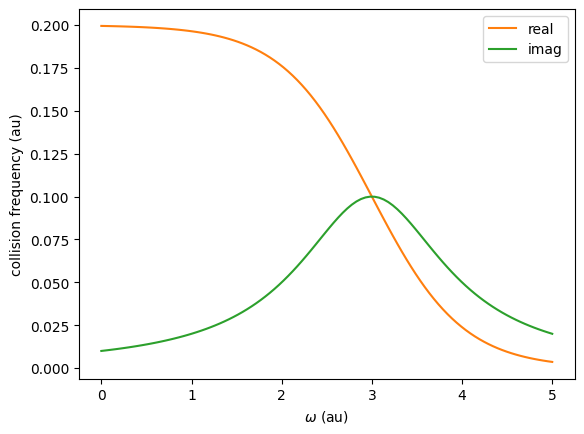

In [29]:
# define the real and imaginary parts of the collision frequency
def recollfreq(ω):
    return 0.2 / (1 + np.exp((ω - 3)*2))

def imagcollfreq(ω):
    return 0.1 / ((ω - 3)**2 + 1)

def collfreq(ω):
    return recollfreq(ω) + 1j * imagcollfreq(ω)

# plot the collision frequency
plt.plot(ω, collfreq(ω).real, label="real", color='C1')
plt.plot(ω, collfreq(ω).imag, label="imag", color='C2')
plt.xlabel(r"$\omega$ (au)")
plt.ylabel("collision frequency (au)")
plt.legend()

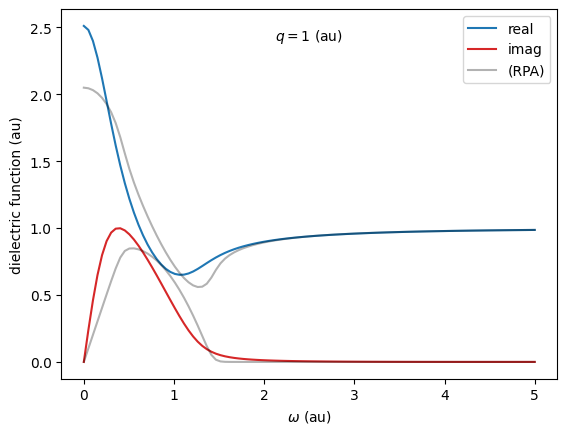

In [41]:
dielectric_mermin = Mermin(electrons_nonideal_correct, collfreq=collfreq)

mermin_results = dielectric_mermin(q, ω)

# plot the results
plt.plot(ω, mermin_results.real, label='real', color="C0")
plt.plot(ω, mermin_results.imag, label='imag', color="C3")

# underlay rpa results for comparison
plt.plot(ω, rpa_results.real, color="black", alpha=0.3)
plt.plot(ω, rpa_results.imag, color="black", alpha=0.3)
plt.plot(0, 0, color="black", alpha=0.3, label="(RPA)")

plt.xlabel(r"$\omega$ (au)")
plt.ylabel("dielectric function (au)")
plt.text(2.5, 2.5, r"$q = 1$ (au)", {"horizontalalignment":"center", "verticalalignment":"top"})
plt.legend()

In the final plot, the Mermin dielectric function results are overlayed on the RPA results (in grey) to highlight the differences between these two methods.